In [1]:
# PYTHON PACKAGES USED
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import pandas as pd # module for data analysis
import geopandas as gpd # module for data analysis

In [2]:
# set up the geocoder
app = Nominatim(user_agent="JournalDev")

In [145]:
# get the source data as a dataframe
xlfile = pd.read_excel('../data/raw/Air Quality Analysis.xlsx', sheet_name='MAP LTN + Regular')

/Users/joe/.pyenv/versions/miniforge3/envs/conda_env/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Web Extension extension is not supported and will be removed
  warn(msg)


In [146]:
# remove rows with NA values
xlfile.dropna(inplace=True)

In [147]:
# check column names
xlfile.columns
# note that the Location column name has a trailing space
# the Result column is presumably NO2 micrograms per cubic meter

Index(['Location ', 'Result'], dtype='object')

In [148]:
# strip trailing spaces from column names
xlfile = xlfile.rename(columns=lambda x: x.strip())

In [149]:
# remove both Bromley and newline character (stops Nominatim from working)
xlfile['Location'].replace(to_replace=['Bromley','\n.*'], value='', regex=True, inplace=True)

In [150]:
# remove street name after school (stops Nominatim from working)
xlfile['Location'].replace(to_replace='School,[^,]*,', value='School,', regex=True, inplace=True)

In [266]:
xlfile.head()

,Location,Result,Longitude,Latitude
0,"290 Brownhill Rd, London, SE6 1AU",34.0,-0.006304,51.445074
1,"baring road, london, se12",33.4,0.021285,51.432353
2,"Bell Green, London,",32.5,-0.037459,51.430748
3,"montpelier vale, blackheath, london",31.2,0.008612,51.466384
4,"New Cross Rd, London, SE14 6AR",30.1,-0.039447,51.475109


In [110]:
# function to geocode a location
def geocode_ltn(row):
    import time
    import numpy
    try:
        time.sleep(1)
        location = app.geocode(row['Location'])
        return [numpy.float64(location.raw['lon']), numpy.float64(location.raw['lat'])]
    except Exception as e:
        return None


In [152]:
# apply the function to the dataframe
xlfile = pd.concat([xlfile, xlfile.apply(geocode_ltn, axis=1,result_type='expand')], axis=1)
# name the newly created long lat columns
xlfile.rename(columns={0:"Longitude", 1:"Latitude"}, inplace=True)

'NoneType' object has no attribute 'raw'
'NoneType' object has no attribute 'raw'
'NoneType' object has no attribute 'raw'
'NoneType' object has no attribute 'raw'
'NoneType' object has no attribute 'raw'
'NoneType' object has no attribute 'raw'
'NoneType' object has no attribute 'raw'
'NoneType' object has no attribute 'raw'


,Location,Result,Longitude,Latitude
0,"290 Brownhill Rd, London, SE6 1AU",34.0,-0.006304,51.445074
1,"baring road, london, se12",33.4,0.021285,51.432353
2,"Bell Green, London,",32.5,-0.037459,51.430748
3,"montpelier vale, blackheath, london",31.2,0.008612,51.466384
4,"New Cross Rd, London, SE14 6AR",30.1,-0.039447,51.475109
...,...,...,...,...
96,"12 Pragnell Road, London, SE12 0LF",17.4,0.020850,51.437360
97,"Dacres Rd, Lewisham, London",17.4,-0.047564,51.431476
98,"193 George Lane, London, SE13 6RY",16.7,-0.007804,51.449719
99,"Downham Way,",16.6,0.020702,51.430688


In [153]:
# look for non geocoded locations
xlfile[xlfile.Longitude.isna()]

,Location,Result,Longitude,Latitude
17,,26.9,NaN,NaN
54,1 Plough WayLondon SE16 2LS,21.1,NaN,NaN
67,"Lucas Vale Primary School, London, SE8 4QF",20.2,NaN,NaN
72,"Christ Church C E Primary School, Forest Hill,...",19.7,NaN,NaN
73,"St James Hatcham School, London, SE14 6AD",19.6,NaN,NaN
80,"51 Polstead Road, London, SE6 4YH",19.1,NaN,NaN
86,"St Mary Magdalen's, Howson Road, London SE4 2BB",17.8,NaN,NaN
92,"Ashmead Primary School, London SE8 4DX",17.6,NaN,NaN


In [154]:
# output to csv
xlfile.to_csv('../data/processed/ltn-plus-regular-sensors-geocoded.csv', index=False)

In [268]:
# create a geometry series from the long lat columns
geometry = gpd.points_from_xy(xlfile.Longitude, xlfile.Latitude, crs="EPSG:4326")

In [329]:
# create a geo dataframe from the data + geometry series
gdf = gpd.GeoDataFrame(data=xlfile, crs="EPSG:4326", geometry=geometry)

In [330]:
# remove the long lat columns (they are now in the geometry column)
gdf.drop(['Longitude', 'Latitude'], axis=1, inplace=True)

In [343]:
# check non geocoded locations
gdf[gdf.is_empty]

,Location,Result,geometry
17,,26.9,GEOMETRYCOLLECTION EMPTY
26,"119 Sandhurst Rd, London SE6 1UR",25.5,GEOMETRYCOLLECTION EMPTY
28,"Oakridge Rd,",25.3,GEOMETRYCOLLECTION EMPTY
37,"Sparta Street, London",23.6,GEOMETRYCOLLECTION EMPTY
54,1 Plough WayLondon SE16 2LS,21.1,GEOMETRYCOLLECTION EMPTY
67,"Lucas Vale Primary School, London, SE8 4QF",20.2,GEOMETRYCOLLECTION EMPTY
72,"Christ Church C E Primary School, Forest Hill,...",19.7,GEOMETRYCOLLECTION EMPTY
73,"St James Hatcham School, London, SE14 6AD",19.6,GEOMETRYCOLLECTION EMPTY
76,"Montague Avenue, London",19.4,GEOMETRYCOLLECTION EMPTY
79,"19 Manor Road, Beckenham, BR3 5JB",19.2,GEOMETRYCOLLECTION EMPTY


<AxesSubplot:>

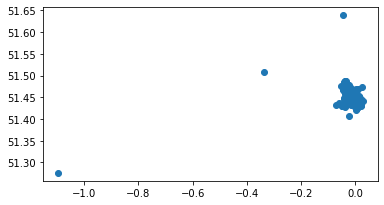

In [331]:
# remove empty geometries and explore the data for baddly geocoded fields
gdf[~gdf.is_empty].plot()
# oh dear, there are some bad geocoded fields

In [235]:
# get lewisham geometry so we can remove points outside it
lewisham = gpd.read_file('https://gist.githubusercontent.com/joe-liad/e66e2ec493ce3de692595b64eeb27b99/raw/bfaafeec350dfe4e5a20866a4660a188f8e6df7d/lewisham-wards.geojson')

<AxesSubplot:>

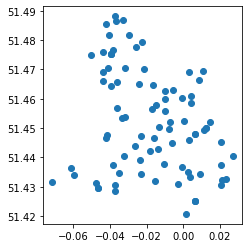

In [341]:
# check within
gdf[gdf.within(lewisham.geometry.unary_union)].plot()

In [333]:
# check not within
gdf[~gdf.within(lewisham.geometry.unary_union)]
# some are not within the lewisham wards, and some didn't geocode

,Location,Result,geometry
17,,26.9,POINT EMPTY
26,"119 Sandhurst Rd, London SE6 1UR",25.5,POINT (-0.04348 51.63910)
28,"Oakridge Rd,",25.3,POINT (-1.09628 51.27597)
37,"Sparta Street, London",23.6,POINT (-0.01487 51.47187)
54,1 Plough WayLondon SE16 2LS,21.1,POINT EMPTY
67,"Lucas Vale Primary School, London, SE8 4QF",20.2,POINT EMPTY
72,"Christ Church C E Primary School, Forest Hill,...",19.7,POINT EMPTY
73,"St James Hatcham School, London, SE14 6AD",19.6,POINT EMPTY
76,"Montague Avenue, London",19.4,POINT (-0.33533 51.50760)
79,"19 Manor Road, Beckenham, BR3 5JB",19.2,POINT (-0.02300 51.40735)


In [334]:
# nullify the badly geocoded locations
from shapely.geometry import Point
for index, row in gdf[~gdf.within(lewisham.geometry.unary_union)].iterrows():
    gdf.loc[index, 'geometry'] = Point()

In [340]:
gdf[gdf.is_empty]

,Location,Result,geometry
17,,26.9,GEOMETRYCOLLECTION EMPTY
26,"119 Sandhurst Rd, London SE6 1UR",25.5,GEOMETRYCOLLECTION EMPTY
28,"Oakridge Rd,",25.3,GEOMETRYCOLLECTION EMPTY
37,"Sparta Street, London",23.6,GEOMETRYCOLLECTION EMPTY
54,1 Plough WayLondon SE16 2LS,21.1,GEOMETRYCOLLECTION EMPTY
67,"Lucas Vale Primary School, London, SE8 4QF",20.2,GEOMETRYCOLLECTION EMPTY
72,"Christ Church C E Primary School, Forest Hill,...",19.7,GEOMETRYCOLLECTION EMPTY
73,"St James Hatcham School, London, SE14 6AD",19.6,GEOMETRYCOLLECTION EMPTY
76,"Montague Avenue, London",19.4,GEOMETRYCOLLECTION EMPTY
79,"19 Manor Road, Beckenham, BR3 5JB",19.2,GEOMETRYCOLLECTION EMPTY


In [344]:
gdf[gdf.within(lewisham.geometry.unary_union)].explore(column="Result", legend=True, cmap='OrRd', marker_kwds={'radius': 5}, tiles='Stamen Terrain')

In [323]:
# create GeoJSON
gdf.to_file('../data/processed/ltn-plus-regular-sensors-geocoded.geojson', driver='GeoJSON')